##### Multiple strategies:

##### Atemporal regression.
Do a standard randomized split on the data.
Train up a polynomial, degree 2 LASSO model on selected parameters from visualizations.
Test model to see if it holds water.
Look at coefficients & suggest interventions to reverse attendance declines.

##### Time series.
Split data into 20th & 21st century, train & test.
Train up a similar model.
See how much adding the time factor adds to the fit (representing external cultural changes).
Change train / test splits as needed.
Project the 2020s with various rules / culture interventions.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
with open('bat_rate_data.pkl','rb') as cellar:
    bat_df = pickle.load(cellar)
with open('pitch_rate_data.pkl','rb') as cellar:
    pitch_df = pickle.load(cellar)
with open('field_rate_data.pkl','rb') as cellar:
    field_df = pickle.load(cellar)
# with open('sp.pkl','rb') as cellar:
#    sp_df = pickle.load(cellar)
# with open('sb.pkl','rb') as cellar:
#    sb_df = pickle.load(cellar)
with open('att.pkl','rb') as cellar:
    att_df = pickle.load(cellar)

###### Target:
* NormAtt/G * 1000000 (or Att)
= attendance per game in units of parts per million of the U.S. population (using ppm because as a fraction it's really small and seaborn actually gagged on it in some of the pairplots & treated it as zero); the calculation was already done in the visualization notebooks

###### Flagship parameters for model:
* BA, SLG, HR/G, 'SB/G', SH/G, SO9, ERA, DefEff, GmDur

###### "On-deck" parameters:
* IBB/G, 'CS/G', '3B/G', SF/G, DP/G, A/G, Fld% 

In [69]:
y = pd.DataFrame(pitch_df['Att'])

In [3]:

X = [bat_df['BA'],bat_df['SLG'],bat_df['HR/G'],
     bat_df['SB/G'],bat_df['SH/G'],pitch_df['SO9'],
     pitch_df['ERA'],field_df['DefEff'],att_df['GmDur'],
     bat_df['IBB/G'],bat_df['CS/G'],bat_df['3B/G'],
     bat_df['SF/G'],field_df['DP/G'],field_df['A/G'],
     field_df['Fld%']]
X = pd.DataFrame(X)
X = X.transpose()
# X = X.fillna(0)

Let me go back to the visualization notebooks and comment on the distribution of each of these variables individually:
* Att: Bimodal and skewed high.
* BA: Skewed a bit low.
* SLG: Skewed high with a narrow peak.
* HR/G: Oooh. Ugly. Peak at near zero and then a divot and then a skewed low distribution. Should consider dropping that one, or cutting the pre-1920 era which would (check!) get rid of that awful low end.
* SB/G: Ugly, bimodal, both flat square dists.
* SH/G: Ugly, bimodal, the upper end skewed high (dead ball era?).
* SO9: ANOTHER bimodal, big low mode, broad high mode.
* ERA: Just skewed high.
* DefEff: Double peak, skewed high.
* GmDur: Ugly, *tri*modal.
* IBB/G: Mostly normal, split peak, skewed a bit high.
* CS/G: Skewed hard low.
* 3B/G: Bimodal, low mode skewed hard low, upper mode skewed high.
* SF/G: Ugly, patchy, and of course has only been tracked since the 50s.
* DP/G: Narrow single mode with long low tail.
* A/G: Bimodal.
* Fld%: Hard high skew.

#### Conclusion:
I rather think there's a LOT to be said for cutting at 1920 and dropping the dead ball era. The noise in that data is extreme, the trends are different.

In [70]:
y = y.loc[1920:2019]
print(y.head(2),y.tail(2))

            Att
1920  69.425136
1921  64.519993             Att
2018  87.725367
2019  85.906654


In [5]:
X = pd.concat([bat_df['Year'],X],axis=1)
X = X.loc[1920:2019]

In [6]:
X.head(2)

,Year,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,GmDur,IBB/G,CS/G,3B/G,SF/G,DP/G,A/G,Fld%
1920,1920.0,0.276,0.372,0.253247,0.701299,1.233766,2.9,3.46,0.685,NaN,NaN,0.636364,0.512987,NaN,0.798701,13.370130,0.966
1921,1921.0,0.291,0.403,0.383117,0.603896,1.214286,2.8,4.03,0.677,NaN,NaN,0.532468,0.551948,NaN,0.883117,12.980519,0.966


Ok, let's redo a correlation matrix.

In [7]:
yX = pd.concat([y,X],axis=1)
Rmat = yX.corr()
Rmat.sort_values('Att',ascending=False)

,Att,Year,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,GmDur,IBB/G,CS/G,3B/G,SF/G,DP/G,A/G,Fld%
Att,1.000000,0.732923,-0.276980,0.398534,0.664850,0.459241,-0.541370,0.630233,0.273438,0.010320,0.689743,-0.196397,0.182858,-0.642233,0.567671,-0.062967,-0.629353,0.754517
Fld%,0.754517,0.965913,-0.620299,0.322541,0.875272,0.337442,-0.868835,0.932487,0.129550,0.153555,0.941893,-0.405043,-0.110556,-0.938751,0.030554,-0.213739,-0.931195,1.000000
Year,0.732923,1.000000,-0.526298,0.391408,0.858155,0.490860,-0.828362,0.952215,0.189710,-0.011226,0.943118,-0.378388,-0.022346,-0.908637,0.121433,-0.347807,-0.898460,0.965913
GmDur,0.689743,0.943118,-0.325505,0.537747,0.883599,0.481140,-0.827851,0.925341,0.324111,-0.273871,1.000000,-0.345199,0.028231,-0.885362,0.104829,-0.476014,-0.883859,0.941893
HR/G,0.664850,0.858155,-0.405984,0.615283,1.000000,0.201494,-0.799795,0.890854,0.428937,-0.024701,0.883599,-0.473570,-0.224928,-0.799948,-0.083410,-0.107399,-0.901360,0.875272
SO9,0.630233,0.952215,-0.583830,0.382211,0.890854,0.343233,-0.814189,1.000000,0.149785,-0.003993,0.925341,-0.398711,-0.115840,-0.878625,-0.331557,-0.423654,-0.924675,0.932487
SF/G,0.567671,0.121433,0.743926,0.277700,-0.083410,0.581738,0.095456,-0.331557,0.399035,-0.283219,0.104829,0.056840,0.537737,0.095794,1.000000,0.352301,0.248539,0.030554
SB/G,0.459241,0.490860,0.043792,0.214223,0.201494,1.000000,-0.156712,0.343233,0.092082,-0.297500,0.481140,0.140652,0.640674,-0.308980,0.581738,-0.476469,-0.117361,0.337442
SLG,0.398534,0.391408,0.460079,1.000000,0.615283,0.214223,-0.167932,0.382211,0.935518,-0.713701,0.537747,-0.525476,-0.198151,-0.105824,0.277700,-0.015949,-0.354489,0.322541
ERA,0.273438,0.189710,0.604029,0.935518,0.428937,0.092082,-0.056693,0.149785,1.000000,-0.728558,0.324111,-0.534978,-0.276169,0.057263,0.399035,0.168058,-0.201162,0.129550


Keeping in mind insights from below, the top four allowable stats:
* Fld%
* HR/G
* 3B/G
* SO9

That's a nice mix: one apiece of fielding, hitting, speed, pitching.

In [8]:
X = X.fillna(0)
for col in X.columns:
    model = sm.OLS(y,sm.add_constant(X[col]))
    results = model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           4.38e-18
Time:                        15:58:42   Log-Likelihood:                -398.74
No. Observations:                 100   AIC:                             801.5
Df Residuals:                      98   BIC:                             806.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -876.6920     89.922     -9.749      0.0

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     84.53
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           6.80e-15
Time:                        15:58:42   Log-Likelihood:                -406.16
No. Observations:                 100   AIC:                             816.3
Df Residuals:                      98   BIC:                             821.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.7219      3.609     14.330      0.0

In [9]:
len(X.columns)

17

IndexError: index 4 is out of bounds for axis 0 with size 4

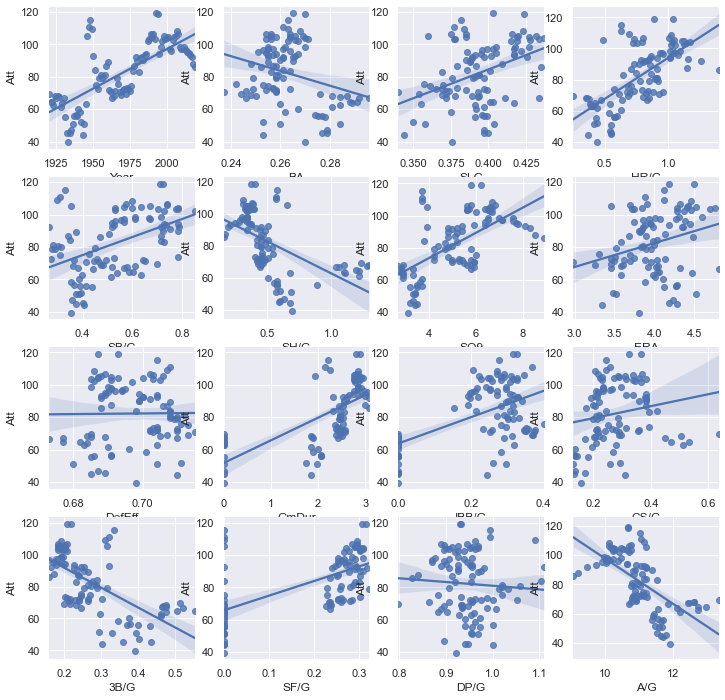

In [10]:
f,axes = plt.subplots(4, 4, figsize=(12,12))
sns.despine(left=True)
for i, col in enumerate(X.columns):
    sns.regplot(X[col],y,ax=axes[i//4,i%4])
plt.tight_layout()

Right. At this point, I think I need to say farewell to GmDur, IBB/G, SF/G just because I don't want to bother with cutting them down to the eras when those stats are available.

IndexError: index 4 is out of bounds for axis 0 with size 4

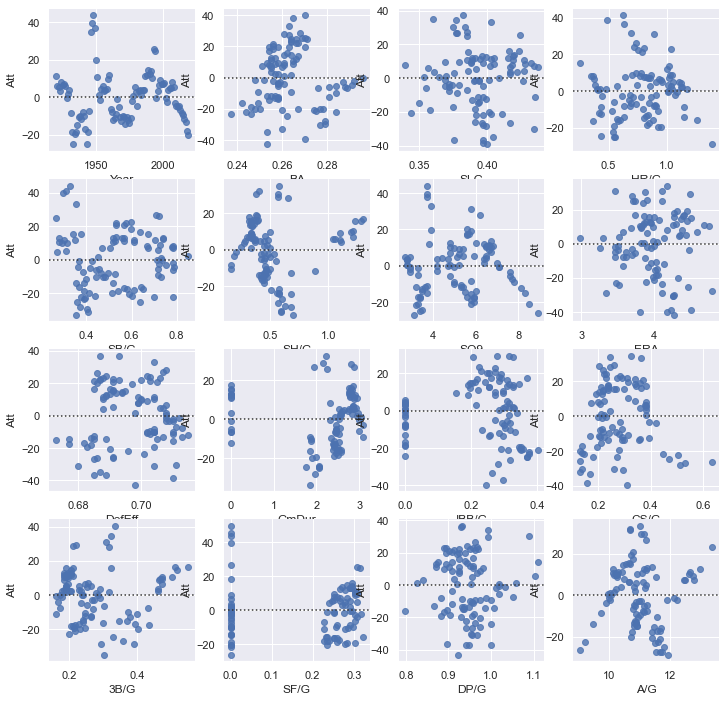

In [11]:
f,axes = plt.subplots(4, 4, figsize=(12,12))
sns.despine(left=True)
for i, col in enumerate(X.columns):
    sns.residplot(X[col],y,ax=axes[i//4,i%4])
plt.tight_layout()

I'm not sure what I've gained beyond looking at the correlation matrix, but by God it looks cool to be able to automate all of that.

Once again, the top four allowable stats:
* Fld%
* HR/G
* 3B/G
* SO9

That's a nice mix: one apiece of fielding, hitting, speed, pitching.
Here's a straight linear regression on those four as a baseline.

In [12]:
# a straight linear regression as a baseline
X1 = pd.concat([X['Fld%'],X['HR/G'],X['3B/G'],X['SO9']],axis=1)

for i in range(3):
    X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
    lin_atemp = LinearRegression()
    lin_atemp.fit(X1tr,y1tr)
    print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
    sm_atemp = sm.OLS(y1tr,sm.add_constant(X1tr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.6357755571791993 0.6670755683208691 

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     28.37
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.20e-13
Time:                        16:00:07   Log-Likelihood:                -272.77
No. Observations:                  70   AIC:                             555.5
Df Residuals:                      65   BIC:                             566.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

That's a wee bit disturbing, the way HR/G has high p-values for 2 out of 3 splits.

0.6617264225143931 0.5896816522443752 



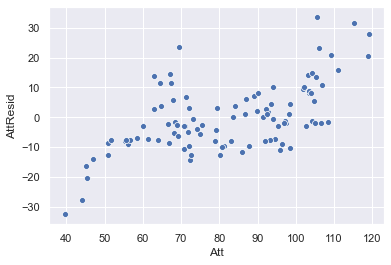

In [13]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

0.6766358751478512 0.43955855929434984 



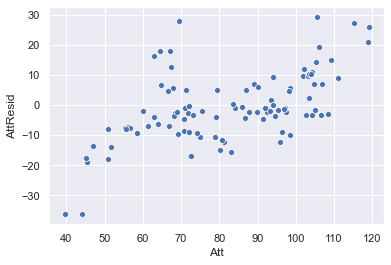

In [14]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

0.6608615635425183 0.5936332033640033 



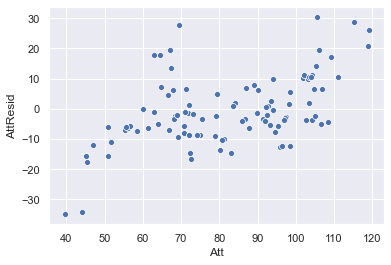

In [15]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

I am calculating the residual as real - predicted, meaning that the model is consistently overpredicting at low real attendance and underpredicting at high real attendance. Polynomial features should be able to do a considerable amount for this.

This model is certainly unstable; I guess I'm not surprised, with only 119 data points. Hopefully I don't have to go back and rethink things completely and try to pull data at the team... or player... level. I don't know that I would have any attendance data to work with.

Of course, I'm throwing messy, random variables into the regression that probably really are unrelated to attendance trends. I can do three things about this:
* Lasso may be able to prune the crap variables in an automated way.
* I'll do Ridge since it's there.
* If I have to, I can go back to my visualizations and prune variables manually.

Beyond that, there is polynomial feature selection. Forgot about that. There would be a blizzard of features at that point, something like as many features as lines of data, if I stick all of X1 in there, so I'll need to prune that down regardless.

At the moment, though, the guidance suggests I try a "full" model with all features. That will probably be a dumpster fire, but there might be some interesting details in the ashes.

In [16]:
del X['GmDur']
del X['IBB/G']
del X['SF/G']

In [17]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.8308799859518169 0.6465611769935654 

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     19.30
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.50e-16
Time:                        16:00:34   Log-Likelihood:                -246.52
No. Observations:                  70   AIC:                             523.0
Df Residuals:                      55   BIC:                             556.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

Compared to what I've seen up to now, that's pretty consistent overfitting. Let's run a handful of Lassos on these bad boys and see who survives.

In [18]:
scaler = StandardScaler()

In [19]:
print(y)
y = np.ravel(y)
print(y)

            Att
1920  69.425136
1921  64.519993
1922  64.706951
1923  62.822689
1924  68.311279
...         ...
2015  94.651322
2016  93.302161
2017  92.027447
2018  87.725367
2019  85.906654

[100 rows x 1 columns]
[ 69.4251362   64.51999263  64.70695139  62.8226887   68.31127859
  67.07243374  67.87052811  67.43951613  61.35590407  64.06339821
  66.70458239  55.22412125  45.30599167  39.54451346  45.05024927
  47.00196464  50.9800859   56.00838379  56.72469573  55.72279951
  60.14986376  58.38830585  51.8166988   44.09828872  51.03323699
  62.98149075 105.48129288 110.93457295 115.33792539 109.27005831
  92.63150982  84.03279959  74.96033005  72.41228618  79.016132
  81.15470379  79.0526939   80.10815211  80.84400732  86.95383231
  89.16256158  71.9255267   70.68725206  66.83047981  68.20053155
  71.16314977  79.32437932  75.51205274  70.83354093  69.03493191
  72.11411851  72.53683906  69.10909957  73.12538342  72.18611176
  71.32009075  74.07356448  83.5724664   86.85416479  92.188

In [20]:
# Lasso
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xtr,ytr)
    print(lasso_atemp.score(Xtr,ytr),lasso_atemp.score(Xv,yv))

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.595090324446214 0.5319370826892843
0.545137480673531 0.6973742590956494
0.6805425663124172 0.3548040374620067


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6413047421734587 0.43025243410383807
0.6193108154480196 0.41394979188911674


Ugh. Those two <0.3 scores on the first two runs are quite chilling. I guess 5 runs is not a good sample size for this...

In [21]:
# Ridge
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    ridge_atemp = RidgeCV()
    ridge_atemp.fit(Xtr,ytr)
    print(ridge_atemp.score(Xtr,ytr),ridge_atemp.score(Xv,yv))

0.754211989456815 0.6588745105204091
0.7817626630817558 0.5343625009949629
0.7371404349810983 0.6997194437708865
0.7782545883687926 0.5194947934529994
0.7201924490389908 0.7421211616955414


That's just bad, not so terrible.

Let me run the Lasso code again and look at the coefficients.

In [22]:
# Lasso
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xtr,ytr)
    out = pd.DataFrame(lasso_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xtr.columns
    print(out,'\n')
    print(lasso_atemp.score(Xtr,ytr),lasso_atemp.score(Xv,yv),'\n')

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


   Year   BA  SLG  HR/G  SB/G  SH/G  SO9   ERA  DefEff  CS/G  3B/G  DP/G  \
0  0.67  0.0  0.0   0.0   0.0   0.0 -5.5  6.25     0.0   0.0   0.0   0.0   

    A/G  Fld%  
0 -1.86   0.0   

0.5257353468890138 0.70348766763543 

   Year   BA  SLG  HR/G  SB/G  SH/G   SO9   ERA  DefEff  CS/G  3B/G  DP/G  \
0  0.97  0.0  0.0   0.0   0.0   0.0 -9.09  1.96     0.0   0.0  -0.0   0.0   

   A/G  Fld%  
0 -0.0   0.0   

0.615038451295734 0.5129097611473228 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


   Year   BA  SLG  HR/G  SB/G  SH/G   SO9  ERA  DefEff  CS/G  3B/G  DP/G  A/G  \
0  0.71  0.0  0.0   0.0   0.0   0.0 -5.14  3.7     0.0   0.0   0.0   0.0 -0.0   

   Fld%  
0   0.0   

0.5097396544505823 0.7467417086933168 

   Year   BA  SLG  HR/G  SB/G  SH/G   SO9  ERA  DefEff  CS/G  3B/G  DP/G  A/G  \
0  0.83 -0.0  0.0   0.0  -0.0   0.0 -8.53  0.0     0.0   0.0  -0.0   0.0 -0.0   

   Fld%  
0   0.0   

0.5626784834963323 0.5395227847155774 

   Year   BA  SLG  HR/G  SB/G  SH/G   SO9   ERA  DefEff  CS/G  3B/G  DP/G  \
0  0.75  0.0  0.0   0.0   0.0   0.0 -6.09  4.82     0.0   0.0   0.0   0.0   

   A/G  Fld%  
0 -0.0   0.0   

0.5945171575531605 0.5327625629306629 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Features with all zero coefficients:
BA, SLG, DefEff, Fld%

Features with consistent coefficients:
* A/G - of all things. Always negative and reasonably constant magnitude.

Features with consistent sign:
* HR/G - always positive. (Chicks dig the long ball.)
* SB/G - always positive.
* SH/G (bunts) - always positive.
* SO9 - always negative.
* ERA - always positive.
* CS - always positive.
* DP/G - always positive...hanging on that once...

Other:
* 3B/G - sometimes negative, sometimes zero.

In [23]:
# Ridge
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    ridge_atemp = RidgeCV()
    ridge_atemp.fit(Xtr,ytr)
    out = pd.DataFrame(ridge_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xtr.columns
    print(out,'\n')
    print(ridge_atemp.score(Xtr,ytr),ridge_atemp.score(Xv,yv),'\n')

   Year    BA   SLG  HR/G  SB/G   SH/G    SO9  ERA  DefEff   CS/G  3B/G  \
0   0.8 -1.92 -1.82  31.4  9.14  29.33 -15.91  2.4     7.2  54.83  4.43   

    DP/G    A/G  Fld%  
0  31.19 -21.07  3.56   

0.7374507399200454 0.6527151960595309 

   Year    BA   SLG   HR/G   SB/G   SH/G    SO9   ERA  DefEff   CS/G  3B/G  \
0  0.48 -0.04  1.95  30.38  13.25  33.28 -14.71  0.68    3.46  74.02  1.12   

   DP/G    A/G  Fld%  
0 -4.57 -30.69   2.6   

0.7213606587662087 0.7437543973737433 

   Year   BA   SLG   HR/G   SB/G   SH/G    SO9   ERA  DefEff  CS/G  3B/G  \
0  0.62 -1.9 -0.15  34.88  15.06  18.06 -10.47  2.96    6.39  42.3 -2.27   

   DP/G    A/G  Fld%  
0  12.1 -10.28   2.8   

0.7574900976872063 0.5611065720161063 

   Year    BA   SLG  HR/G   SB/G   SH/G    SO9   ERA  DefEff   CS/G  3B/G  \
0  0.68 -2.31 -2.52  26.5  10.64  26.69 -13.37  2.54    5.94  52.22 -9.24   

    DP/G    A/G  Fld%  
0  13.27 -17.68  2.31   

0.7496354933533202 0.6443070237575479 

   Year    BA   SLG   HR/G  

Oscillating signs:
* BA, SLG

Doesn't provide a lot of other guidance. On this showing, the other 11 features could all be valuable.

Features with |corr| > 0.74 with Att: (from the early form of the bb-regress notebook, may not quite jive with the above)
* HR/G
* A/G
* Fld%
* 3B/G

Features with 0.67 < |corr| < 0.74 with Att:
* GmDur
* SF/G
* SH/G
* SO9
* IBB/G

The top four allowable stats from above, based on correlation coefficient and data coverage, were:

    Fld%
    HR/G
    3B/G
    SO9

Taking the lasso results into account, I think I will bump Fld% and replace it with A/G after all. That still has the same mixture of hitting, pitching, speed, and fielding metrics. 

I realize that precisely because there is probably a polynomial relationship between a number of these variables, the linear correlation coefficients may be bad for important variables, but this is where I'll start. I wish I could just throw six or ten features in, poly=2 them, and regress against 10,000 data points, but I've backed myself into this problem, still suspect it's worth trying, and I will do what I can. After this first cut I will consult the pairplots in my visualization notebooks again to look for arched data.

In [24]:
Xp = pd.concat([X['HR/G'],X['SO9'],X['3B/G'],X['A/G']],axis=1)
Xp.head(2)

,HR/G,SO9,3B/G,A/G
1920,0.253247,2.9,0.512987,13.370130
1921,0.383117,2.8,0.551948,12.980519


In [25]:
pf = PolynomialFeatures(degree=2)
pf.fit(Xp)
pf.get_feature_names(input_features=list(Xp.columns))

['1',
 'HR/G',
 'SO9',
 '3B/G',
 'A/G',
 'HR/G^2',
 'HR/G SO9',
 'HR/G 3B/G',
 'HR/G A/G',
 'SO9^2',
 'SO9 3B/G',
 'SO9 A/G',
 '3B/G^2',
 '3B/G A/G',
 'A/G^2']

In [26]:
Xparr = pf.transform(Xp)
Xparr

array([[1.00000000e+00, 2.53246753e-01, 2.90000000e+00, ...,
        2.63155675e-01, 6.85870299e+00, 1.78760373e+02],
       [1.00000000e+00, 3.83116883e-01, 2.80000000e+00, ...,
        3.04646652e-01, 7.16457244e+00, 1.68493886e+02],
       [1.00000000e+00, 4.25806452e-01, 2.80000000e+00, ...,
        2.53236212e-01, 6.41856400e+00, 1.62685911e+02],
       ...,
       [1.00000000e+00, 1.25925926e+00, 8.30000000e+00, ...,
        2.77777778e-02, 1.57716049e+00, 8.95476680e+01],
       [1.00000000e+00, 1.14814815e+00, 8.50000000e+00, ...,
        2.98734949e-02, 1.58862978e+00, 8.44810623e+01],
       [1.00000000e+00, 1.39506173e+00, 8.90000000e+00, ...,
        2.57582686e-02, 1.45137936e+00, 8.17796449e+01]])

In [27]:
Xparr_cols = pf.get_feature_names(input_features=list(Xp.columns))
Xpp = pd.DataFrame(Xparr,columns=Xparr_cols,index=Xp.index)
Xpp.head(2)

,1,HR/G,SO9,3B/G,A/G,HR/G^2,HR/G SO9,HR/G 3B/G,HR/G A/G,SO9^2,SO9 3B/G,SO9 A/G,3B/G^2,3B/G A/G,A/G^2
1920,1.0,0.253247,2.9,0.512987,13.370130,0.064134,0.734416,0.129912,3.385942,8.41,1.487662,38.773377,0.263156,6.858703,178.760373
1921,1.0,0.383117,2.8,0.551948,12.980519,0.146779,1.072727,0.211461,4.973056,7.84,1.545455,36.345455,0.304647,7.164572,168.493886


In [28]:
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xpp.columns
    print(out,'\n')
    print(lasso_atemp.score(Xpsc,yptr),lasso_atemp.score(Xpvsc,ypv),'\n')

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.20544944656831, tolerance: 1.6771772380319336
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.89052167723912, tolerance: 1.6771772380319336
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not conver

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.193712405512997, tolerance: 2.356107087065298
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.110872220520832, tolerance: 2.356107087065298
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.40706529706222, tolerance: 2.356107087065298
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

     1  HR/G  SO9  3B/G    A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0   0.0  0.0  -0.0 -13.85  -10.48     -4.34     -16.58     40.61  -4.87   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0     -1.33      0.0   20.52       0.0   -0.0   

0.5907372537598444 0.028226431695717258 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.42763249190284, tolerance: 2.277848129021442
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.87971280328293, tolerance: 2.277848129021442
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.86592683920571, tolerance: 2.277848129021442
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558.445083087322, tolerance: 2.124530874072393
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2086174756259425, tolerance: 2.2654529701474995
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converg

     1  HR/G  SO9  3B/G  A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  5.18  0.0  -0.0 -0.0    2.56       0.0       -0.0      2.12    0.0   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0     -2.91     3.71    -0.0      -0.0   -0.0   

0.5271165449820239 -0.27275046239297174 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.10158268594387, tolerance: 2.2654529701474995
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.36197232226004, tolerance: 2.2654529701474995
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.73029207338914, tolerance: 2.2654529701474995
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.413667738786899, tolerance: 1.9380145209916975
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.992990301378995, tolerance: 1.9380145209916975
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.578084630355079, tolerance: 1.9380145209916975
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

     1   HR/G  SO9  3B/G  A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  10.27  0.0  -0.0 -0.0     0.0       0.0      -2.11      3.64    0.0   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0     -1.87      0.0     0.0      -0.0   -0.0   

0.4873770854486106 0.5556327799960203 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.604571822466824, tolerance: 1.9391971403086217
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.856426181302595, tolerance: 1.9391971403086217
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.82966639769438, tolerance: 1.9391971403086217
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

     1   HR/G  SO9  3B/G    A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  63.31 -0.0  -0.0 -10.52  -34.78    -18.14     -31.13     33.71  -5.53   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      2.35   -10.75   22.83     13.82 -12.54   

0.565582216012373 0.7607956469177599 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.446374499706508, tolerance: 1.8820323110549653
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.62795219723375, tolerance: 1.8820323110549653
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not conve

     1   HR/G  SO9  3B/G   A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  45.71 -0.0  -0.0 -5.88  -32.02     -8.76     -32.98     44.73 -11.13   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      5.58   -11.83   23.88      9.33 -15.25   

0.6279776237396395 0.4435878376070027 



/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3479174616868477, tolerance: 1.729738798744311
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.046475243797431, tolerance: 1.729738798744311
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.415906152129537, tolerance: 1.729738798744311
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

It converged five times, but it's unstable as hell. Delightful.

I want p values for each polynomial feature to see what that looks like. The coefficients themselves only tell me a little. I can look at some stuff from statsmodels for an interactive model.

Although now that I'm thinking about it, I'm a little ahead of myself, since I haven't actually done a straight linear regression yet as a baseline.

In [29]:
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lin_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xpp.columns
    print(out,'\n')
    print(lin_atemp.score(Xpsc,yptr),lin_atemp.score(Xpvsc,ypv),'\n')

     1    HR/G     SO9  3B/G    A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  \
0  0.0 -410.31 -376.47  17.7 -964.3   24.46     36.63     -14.38    323.01   

   SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G   A/G^2  
0  24.09    -10.75    270.1   -0.53     35.68  781.26   

0.6943667022841784 -0.7815739833365477 

     1    HR/G     SO9    3B/G      A/G  HR/G^2  HR/G SO9  HR/G 3B/G  \
0  0.0 -717.77 -686.08 -123.77 -1397.04   26.69    162.38      -2.82   

   HR/G A/G  SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G    A/G^2  
0    507.97   27.5    -11.24   462.21  -34.29    226.16  1079.35   

0.7104065642898074 0.31475755311032777 

     1    HR/G    SO9    3B/G      A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  \
0  0.0 -821.86 -480.2  240.46 -1736.68   31.57    192.21      -2.05    572.91   

   SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G   A/G^2  
0 -89.46    -32.46    424.2  -29.27    -142.4  1471.6   

0.6829984135376919 0.47542611742892293 

     1    HR/G     SO9   3B/G      A/G  HR/G^2  

That's incredibly bad overfitting. Let me go back to the lasso results and see if I can store a list of dataframes and pile them together at the end for ease of readout.

In [30]:
output = []
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2s.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.598206270902665, tolerance: 2.080902681957055
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.180945060492377, tolerance: 2.080902681957055
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converg

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.80388034876978, tolerance: 1.6772638717049873
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.42747692701869, tolerance: 1.6772638717049873
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.15291894082475, tolerance: 1.6772638717049873
  tol, rng, random, positive)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

NameError: name 'X2s' is not defined

In [31]:
out_df

NameError: name 'out_df' is not defined

Using my paper notebook to assess two things:
* The statsmodels output on the full linear regression stable.
* The viability of individual variables as linear or lin + quad combos.

Four statsmodels runs had CS/G and Fld% with the lowest p-values.
Three runs also had SH/G, A/G.

* BA looks like two linear trends. Throw it in linear only.
* HR/G is a broad line. Linear, although the above results suggest quadratic.
* SO9: quad + lin
* Pitchers/G: pull this in from att_df and quad + lin
* GmDur: fortunately is close to linearly dependent on Pitchers/G, skip
* 3B: quad + lin
* SH: quad + lin (give the people what they want...)
* Fld%: quad + lin
* A/G: somewhat close to collinear with Fld%
That's 12 parameters (two lins & five quad + lin).
* Consider CS/G from statsmodels, either lin or quad + lin.
I'll try running statsmodels on all 14, then cutting down manually, then compare that to lasso and ridge.

In [32]:
pg = att_df['Pitchers/G']
pg = pg.loc[1920:2019]
X2s = pd.concat([X['BA'],X['HR/G'],X['SO9'],pg,
                X['3B/G'],X['SH/G'],X['Fld%']],axis=1)
X2s['SO9^2'] = X2s['SO9']**2
X2s

,BA,HR/G,SO9,Pitchers/G,3B/G,SH/G,Fld%,SO9^2
1920,0.276,0.253247,2.9,1.62,0.512987,1.233766,0.966,8.41
1921,0.291,0.383117,2.8,1.74,0.551948,1.214286,0.966,7.84
1922,0.288,0.425806,2.8,1.79,0.503226,1.193548,0.968,7.84
1923,0.284,0.396104,2.9,1.81,0.461039,1.110390,0.967,8.41
1924,0.287,0.363636,2.7,1.83,0.474026,1.097403,0.970,7.29
...,...,...,...,...,...,...,...,...
2015,0.254,1.012346,7.8,4.11,0.191358,0.246914,0.984,60.84
2016,0.255,1.154321,8.1,4.15,0.179012,0.209877,0.984,65.61
2017,0.255,1.259259,8.3,4.22,0.166667,0.191358,0.984,68.89
2018,0.248,1.148148,8.5,4.36,0.172840,0.166667,0.984,72.25


In [33]:
X2s['PitG^2'] = X2s['Pitchers/G']**2
X2s['3B^2'] = X2s['3B/G']**2
X2s['SH^2'] = X2s['SH/G']**2
X2s['Fld^2'] = X2s['Fld%']**2

In [34]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X2s, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.7678796507092392 0.6731600123626325 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     18.47
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           8.47e-17
Time:                        16:01:37   Log-Likelihood:                -293.29
No. Observations:                  80   AIC:                             612.6
Df Residuals:                      67   BIC:                             643.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

Ye don't say.

In [35]:
Xslow = pd.concat([X2s['Pitchers/G'],
                        X2s['PitG^2']],axis=1)
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(Xslow, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.6614090329088371 0.3759626550607975 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     75.21
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           7.81e-19
Time:                        16:01:40   Log-Likelihood:                -306.27
No. Observations:                  80   AIC:                             618.5
Df Residuals:                      77   BIC:                             625.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

I mean, it would be pretty boring if that were the whole story: "Stop making so damned many pitching swaps!"

Wait. That's the wrong sign. Wait. No, it's not. The game got interesting to a certain point with pitching changes (positive lin term), but too many drags it down (neg square term).

Three pending action items:
* Get Caught Stealing & look at new p-values.
* Lasso this band of stats & compare its results to p-values.
* Consider manually voting stats off the island like back in the old days.

In [36]:
X2s['CS/G'] = X['CS/G']
X2s['CS^2'] = X2s['CS/G']**2

In [37]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X2s, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.7944096134072458 0.7198540767413993 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     17.94
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           3.72e-17
Time:                        16:01:46   Log-Likelihood:                -287.20
No. Observations:                  80   AIC:                             604.4
Df Residuals:                      65   BIC:                             640.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

0.7661915417513293 0.8748462147040952 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     15.21
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.98e-15
Time:                        16:01:47   Log-Likelihood:                -294.96
No. Observations:                  80   AIC:                             619.9
Df Residuals:                      65   BIC:                             655.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

In [38]:
del X2s['SO9^2']
del X2s['SH/G']
del X2s['3B^2']
del X2s['Fld^2']
del X2s['3B/G']

In [39]:
del X2s['Fld%']
del X2s['CS^2']

In [40]:
X2s

,BA,HR/G,SO9,Pitchers/G,PitG^2,SH^2,CS/G
1920,0.276,0.253247,2.9,1.62,2.6244,1.522179,0.636364
1921,0.291,0.383117,2.8,1.74,3.0276,1.474490,0.532468
1922,0.288,0.425806,2.8,1.79,3.2041,1.424558,0.470968
1923,0.284,0.396104,2.9,1.81,3.2761,1.232965,0.512987
1924,0.287,0.363636,2.7,1.83,3.3489,1.204292,0.506494
...,...,...,...,...,...,...,...
2015,0.254,1.012346,7.8,4.11,16.8921,0.060966,0.216049
2016,0.255,1.154321,8.1,4.15,17.2225,0.044048,0.203704
2017,0.255,1.259259,8.3,4.22,17.8084,0.036618,0.191358
2018,0.248,1.148148,8.5,4.36,19.0096,0.027778,0.197531


In [41]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     40.08
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.71e-25
Time:                        16:01:56   Log-Likelihood:                -367.33
No. Observations:                 100   AIC:                             750.7
Df Residuals:                      92   BIC:                             771.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1657     55.538      0.381      0.7

In [42]:
del X2s['SH^2']

In [43]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     45.62
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.28e-25
Time:                        16:02:03   Log-Likelihood:                -368.66
No. Observations:                 100   AIC:                             751.3
Df Residuals:                      93   BIC:                             769.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9639     55.017      0.090      0.9

In [44]:
del X2s['BA']

In [45]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     52.01
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.37e-25
Time:                        16:02:09   Log-Likelihood:                -370.96
No. Observations:                 100   AIC:                             753.9
Df Residuals:                      94   BIC:                             769.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -102.5449     19.829     -5.172      0.0

In [46]:
X3 = X2s.copy()
del X2s['HR/G']

In [47]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     62.33
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           9.67e-26
Time:                        16:02:14   Log-Likelihood:                -372.88
No. Observations:                 100   AIC:                             755.8
Df Residuals:                      95   BIC:                             768.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -115.6298     18.879     -6.125      0.0

In [48]:
fin_atemp = LinearRegression()
fin_atemp.fit(X2s,y)
fin_atemp.score(X2s,y)

0.7240923309547138

In [49]:
yo = np.array(y)
yp = np.array(fin_atemp.predict(X2s))
yd = yo - yp

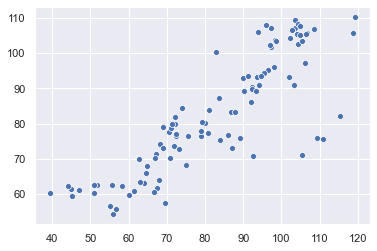

In [50]:
sns.scatterplot(x=yo,y=yp)

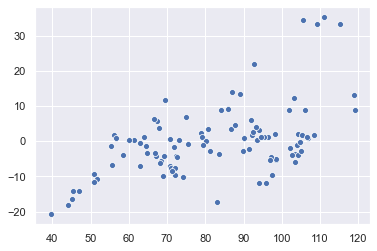

In [51]:
sns.scatterplot(x=yo,y=yd)

In [52]:
yo = yo * 300
yp = yp * 300
yd = yd * 300

Text(0, 0.5, 'Model Deviation')

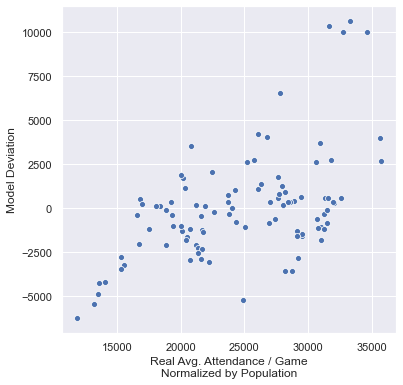

In [53]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=yo,y=yd)
plt.title = 'Attendance Model'
plt.xlabel('Real Avg. Attendance / Game\nNormalized by Population')
plt.ylabel('Model Deviation')

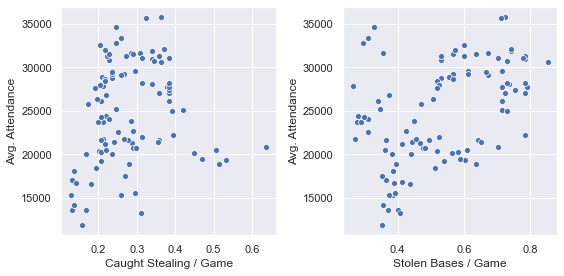

In [54]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X['CS/G'],y=yo)
plt.xlabel('Caught Stealing / Game')
plt.ylabel('Avg. Attendance')
plt.subplot(1,2,2)
sns.scatterplot(x=X['SB/G'],y=yo)
plt.xlabel('Stolen Bases / Game')
plt.ylabel('Avg. Attendance')
plt.tight_layout()
plt.title = 'Steals - Lure of the Unpredictable'

Text(0, 0.5, 'Avg. Attendance')

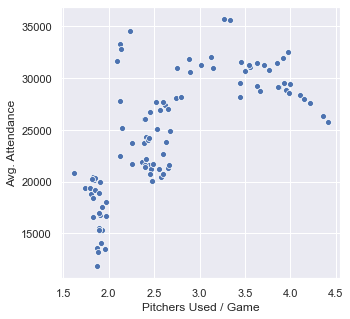

In [55]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=X2s['Pitchers/G'],y=yo)
plt.xlabel('Pitchers Used / Game')
plt.ylabel('Avg. Attendance')

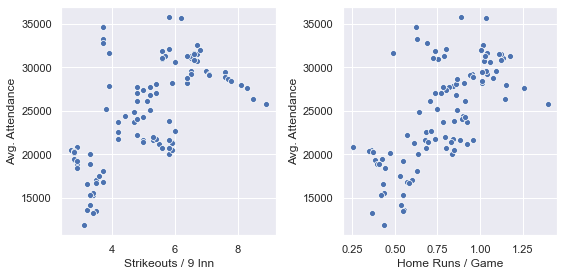

In [56]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X['SO9'],y=yo)
plt.xlabel('Strikeouts / 9 Inn')
plt.ylabel('Avg. Attendance')
plt.subplot(1,2,2)
sns.scatterplot(x=X['HR/G'],y=yo)
plt.xlabel('Home Runs / Game')
plt.ylabel('Avg. Attendance')
plt.tight_layout()

In [71]:
X20 = X.loc[1920:2000]
y20 = y.loc[1920:2000]
y20.head()

,Att
1920,69.425136
1921,64.519993
1922,64.706951
1923,62.822689
1924,68.311279


In [58]:
X20.corr()

,Year,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,CS/G,3B/G,DP/G,A/G,Fld%
Year,1.000000,-0.558597,0.114269,0.800515,0.587135,-0.809014,0.925121,-0.017133,0.306359,0.239962,-0.916255,-0.140417,-0.830540,0.944680
BA,-0.558597,1.000000,0.638639,-0.399839,0.059773,0.701446,-0.631126,0.706848,-0.912418,0.016199,0.795975,0.050763,0.678582,-0.681712
SLG,0.114269,0.638639,1.000000,0.443197,0.211635,0.053523,0.102812,0.941277,-0.698241,-0.082631,0.155875,0.168300,-0.064871,0.028890
HR/G,0.800515,-0.399839,0.443197,1.000000,0.202647,-0.762790,0.861179,0.293299,0.230615,-0.077202,-0.759399,0.163643,-0.861401,0.836793
SB/G,0.587135,0.059773,0.211635,0.202647,1.000000,-0.135088,0.410603,0.076347,-0.287339,0.700094,-0.300844,-0.512988,-0.084171,0.359929
SH/G,-0.809014,0.701446,0.053523,-0.762790,-0.135088,1.000000,-0.798362,0.090037,-0.528346,0.124518,0.897642,-0.090994,0.912796,-0.859200
SO9,0.925121,-0.631126,0.102812,0.861179,0.410603,-0.798362,1.000000,-0.071458,0.341100,0.127483,-0.897516,-0.208279,-0.864736,0.910727
ERA,-0.017133,0.706848,0.941277,0.293299,0.076347,0.090037,-0.071458,1.000000,-0.724423,-0.220842,0.244736,0.294247,-0.004133,-0.090418
DefEff,0.306359,-0.912418,-0.698241,0.230615,-0.287339,-0.528346,0.341100,-0.724423,1.000000,-0.117586,-0.596312,0.203103,-0.504670,0.501984
CS/G,0.239962,0.016199,-0.082631,-0.077202,0.700094,0.124518,0.127483,-0.220842,-0.117586,1.000000,-0.062650,-0.416094,0.222220,0.091695


In [59]:
del X20['GmDur']
del X20['IBB/G']
del X20['SF/G']

KeyError: 'GmDur'

In [60]:
X20.corr()

,Year,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,CS/G,3B/G,DP/G,A/G,Fld%
Year,1.000000,-0.558597,0.114269,0.800515,0.587135,-0.809014,0.925121,-0.017133,0.306359,0.239962,-0.916255,-0.140417,-0.830540,0.944680
BA,-0.558597,1.000000,0.638639,-0.399839,0.059773,0.701446,-0.631126,0.706848,-0.912418,0.016199,0.795975,0.050763,0.678582,-0.681712
SLG,0.114269,0.638639,1.000000,0.443197,0.211635,0.053523,0.102812,0.941277,-0.698241,-0.082631,0.155875,0.168300,-0.064871,0.028890
HR/G,0.800515,-0.399839,0.443197,1.000000,0.202647,-0.762790,0.861179,0.293299,0.230615,-0.077202,-0.759399,0.163643,-0.861401,0.836793
SB/G,0.587135,0.059773,0.211635,0.202647,1.000000,-0.135088,0.410603,0.076347,-0.287339,0.700094,-0.300844,-0.512988,-0.084171,0.359929
SH/G,-0.809014,0.701446,0.053523,-0.762790,-0.135088,1.000000,-0.798362,0.090037,-0.528346,0.124518,0.897642,-0.090994,0.912796,-0.859200
SO9,0.925121,-0.631126,0.102812,0.861179,0.410603,-0.798362,1.000000,-0.071458,0.341100,0.127483,-0.897516,-0.208279,-0.864736,0.910727
ERA,-0.017133,0.706848,0.941277,0.293299,0.076347,0.090037,-0.071458,1.000000,-0.724423,-0.220842,0.244736,0.294247,-0.004133,-0.090418
DefEff,0.306359,-0.912418,-0.698241,0.230615,-0.287339,-0.528346,0.341100,-0.724423,1.000000,-0.117586,-0.596312,0.203103,-0.504670,0.501984
CS/G,0.239962,0.016199,-0.082631,-0.077202,0.700094,0.124518,0.127483,-0.220842,-0.117586,1.000000,-0.062650,-0.416094,0.222220,0.091695


In [72]:
sm_atemp = sm.OLS(y20,sm.add_constant(X20))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     19.66
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.67e-18
Time:                        16:06:56   Log-Likelihood:                -288.32
No. Observations:                  81   AIC:                             606.6
Df Residuals:                      66   BIC:                             642.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4693.2937   1145.981     -4.095      0.0

In [81]:
del X20['SLG']
del X20['HR/G']
del X20['SB/G']

In [82]:
sm_atemp = sm.OLS(y20,sm.add_constant(X20))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     26.12
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.20e-20
Time:                        16:10:36   Log-Likelihood:                -288.37
No. Observations:                  81   AIC:                             600.7
Df Residuals:                      69   BIC:                             629.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4727.5614   1001.651     -4.720      0.0

In [83]:
del X20['BA']
del X20['DefEff']
del X20['DP/G']

In [84]:
sm_atemp = sm.OLS(y20,sm.add_constant(X20))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     36.18
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.85e-22
Time:                        16:10:42   Log-Likelihood:                -289.52
No. Observations:                  81   AIC:                             597.0
Df Residuals:                      72   BIC:                             618.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4685.3051    964.651     -4.857      0.0

In [85]:
del X20['ERA']

In [86]:
sm_atemp = sm.OLS(y20,sm.add_constant(X20))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     40.61
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.05e-22
Time:                        16:10:46   Log-Likelihood:                -290.54
No. Observations:                  81   AIC:                             597.1
Df Residuals:                      73   BIC:                             616.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4832.6800    964.096     -5.013      0.0

In [87]:
mod_temp = LinearRegression()
mod_temp.fit(X20,y20)
mod_temp.score(X20,y20)

0.795682350462585

In [88]:
y21 = y.loc[2001:2019]
X21 = pd.concat([X['Year'],X['SH/G'],X['SO9'],X['CS/G'],X['3B/G'],
                X['A/G'],X['Fld%']],axis=1)
X21.head()

,Year,SH/G,SO9,CS/G,3B/G,A/G,Fld%
1920,1920.0,1.233766,2.9,0.636364,0.512987,13.370130,0.966
1921,1921.0,1.214286,2.8,0.532468,0.551948,12.980519,0.966
1922,1922.0,1.193548,2.8,0.470968,0.503226,12.754839,0.968
1923,1923.0,1.110390,2.9,0.512987,0.461039,12.766234,0.967
1924,1924.0,1.097403,2.7,0.506494,0.474026,12.642857,0.970


In [89]:
X20.columns

Index(['Year', 'SH/G', 'SO9', 'CS/G', '3B/G', 'A/G', 'Fld%'], dtype='object')

In [90]:
X21 = X21.loc[2001:2019]

In [91]:
y21p = mod_temp.predict(X21)
y21p

array([[114.5140876 ],
       [112.65658803],
       [109.86647203],
       [112.55839508],
       [111.95554198],
       [115.43544523],
       [119.47630279],
       [118.74682214],
       [127.49797425],
       [114.77282528],
       [116.00434176],
       [112.0423268 ],
       [114.04047472],
       [115.21290918],
       [111.93746015],
       [115.6166536 ],
       [120.17915175],
       [129.73601038],
       [126.54750899]])

In [92]:
y21.head()

,Att
2001,104.856652
2002,97.368147
2003,95.932577
2004,102.711656
2005,104.277206


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


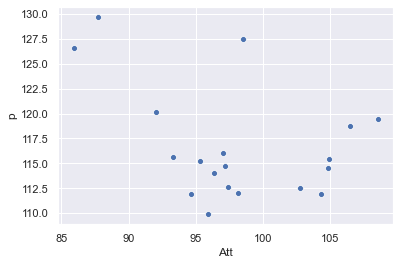

In [93]:
y21['p']=y21p
sns.scatterplot(x='Att',y='p',data=y21)

In [94]:
y21['d']=y21['Att']-y21['p']
y21.head()

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Att,p,d
2001,104.856652,114.514088,-9.657436
2002,97.368147,112.656588,-15.288441
2003,95.932577,109.866472,-13.933895
2004,102.711656,112.558395,-9.846739
2005,104.277206,111.955542,-7.678336


In [95]:
y21=y21*300

Text(0, 0.5, 'Model Error')

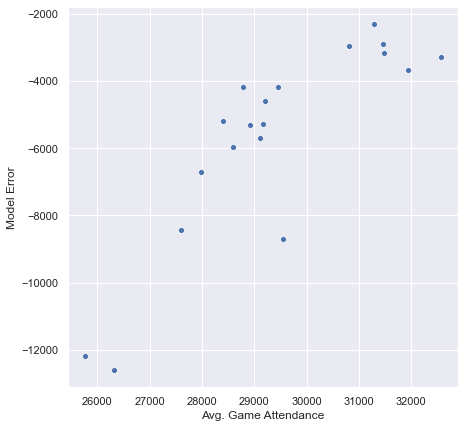

In [96]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='Att',y='d',data=y21)
plt.xlabel('Avg. Game Attendance')
plt.ylabel('Model Error')

In [97]:
y21['Year']=list(y21.index)

In [98]:
y21.head()

,Att,p,d,Year
2001,31456.995473,34354.226280,-2897.230807,2001
2002,29210.443973,33796.976409,-4586.532436,2002
2003,28779.773189,32959.941610,-4180.168420,2003
2004,30813.496807,33767.518524,-2954.021718,2004
2005,31283.161884,33586.662594,-2303.500710,2005


Text(0, 0.5, 'Error in Attendance Prediction')

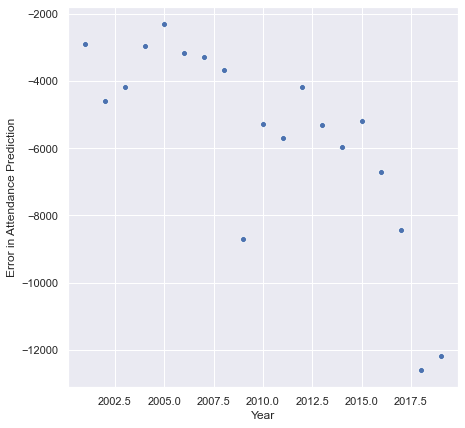

In [99]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='Year',y='d',data=y21)
plt.xlabel('Year')
plt.ylabel('Error in Attendance Prediction')